# Test 2

## Data Parallelism with Multi-devices

In [1]:
import mxnet as mx

In [2]:
def lenet():
    data = mx.sym.Variable('data')
    # first conv
    conv1 = mx.sym.Convolution(data = data, kernel = (5, 5), num_filter = 20)
    tanh1 = mx.sym.Activation(data = conv1, act_type = 'tanh')
    pool1 = mx.sym.Pooling(data = tanh1, pool_type = 'max', kernel = (2, 2), stride = (2, 2))
    # second conv
    conv2 = mx.sym.Convolution(data = pool1, kernel = (5, 5), num_filter = 50)
    tanh2 = mx.sym.Activation(data = conv2, act_type = 'tanh')
    pool2 = mx.sym.Pooling(data = tanh2, pool_type = 'max', kernel = (2, 2), stride = (2, 2))
    # first fullc
    flatten = mx.sym.Flatten(data = pool2)
    fc1 = mx.sym.FullyConnected(data = flatten, num_hidden = 500)
    tanh3 = mx.sym.Activation(data = fc1, act_type = 'tanh')
    # second fullc
    fc2 = mx.sym.FullyConnected(data = tanh3, num_hidden = 10)
    # loss
    lenet = mx.sym.SoftmaxOutput(data = fc2, name = 'out')
    return lenet

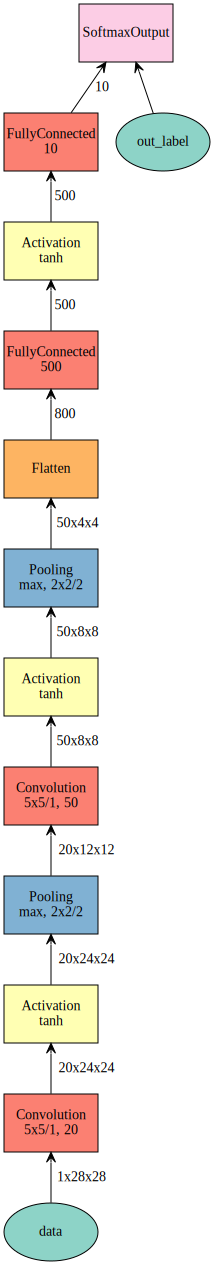

In [5]:
mx.viz.plot_network(lenet(), shape={'data':(128, 1, 28, 28)})